In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    x = vol.shape[1]
    y = vol.shape[2]
    # reshape for labeling
    seg = np.reshape(seg, (length, x*y) )
    vol = np.reshape(vol, (length, x*y) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, x, y, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(24, 20)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

In [33]:
from neutorch.dataset.affinity import TestDataset
from neutorch.dataset.utils import from_h5
import numpy as np

patch_size =  (26,256,256)
stride = (8,80,80)
begin = []
for i in range(len(patch_size)):
    c = patch_size[i] // 2
    o = stride[i] // 2
    begin.append(c-o)
begin = tuple(begin)
print(begin)
dataset = TestDataset('../../data/sample_A_pad.hdf', patch_size, stride, with_label=True)
full = np.zeros(dataset.full_shape)
print(len(dataset))
print(dataset.full_shape)




(9, 88, 88)
loading from ../../data/sample_A_pad.hdf...
25725
(200, 3072, 3072)


In [34]:
for (index, image) in enumerate(dataset):
    (pz,py,px) = patch_size
    (sz,sy,sx) = stride
    (bz,by,bx) = begin
    (iz,iy,ix) = dataset.get_indices(index)
    full[iz+bz:iz+sz+bz, iy+by:iy+sy+by, ix+bx:ix+sx+bx] = image[:, bz:bz+sz,by:by+sy,bx:bx+sx]

(0, 0, 0)
(9, 17) (88, 168) (88, 168)
(0, 0, 80)
(9, 17) (88, 168) (168, 248)
(0, 0, 160)
(9, 17) (88, 168) (248, 328)
(0, 0, 240)
(9, 17) (88, 168) (328, 408)
(0, 0, 320)
(9, 17) (88, 168) (408, 488)
(0, 0, 400)
(9, 17) (88, 168) (488, 568)
(0, 0, 480)
(9, 17) (88, 168) (568, 648)
(0, 0, 560)
(9, 17) (88, 168) (648, 728)
(0, 0, 640)
(9, 17) (88, 168) (728, 808)
(0, 0, 720)
(9, 17) (88, 168) (808, 888)
(0, 0, 800)
(9, 17) (88, 168) (888, 968)
(0, 0, 880)
(9, 17) (88, 168) (968, 1048)
(0, 0, 960)
(9, 17) (88, 168) (1048, 1128)
(0, 0, 1040)
(9, 17) (88, 168) (1128, 1208)
(0, 0, 1120)
(9, 17) (88, 168) (1208, 1288)
(0, 0, 1200)
(9, 17) (88, 168) (1288, 1368)
(0, 0, 1280)
(9, 17) (88, 168) (1368, 1448)
(0, 0, 1360)
(9, 17) (88, 168) (1448, 1528)
(0, 0, 1440)
(9, 17) (88, 168) (1528, 1608)
(0, 0, 1520)
(9, 17) (88, 168) (1608, 1688)
(0, 0, 1600)
(9, 17) (88, 168) (1688, 1768)
(0, 0, 1680)
(9, 17) (88, 168) (1768, 1848)
(0, 0, 1760)
(9, 17) (88, 168) (1848, 1928)
(0, 0, 1840)
(9, 17) (88, 16

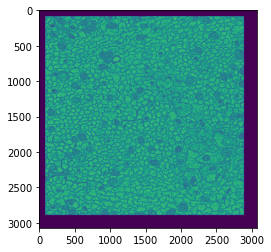

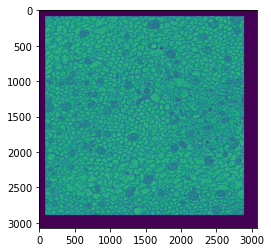

In [43]:
i = 100
plt.imshow(full[17])
plt.show()
plt.imshow(full[176])
plt.show()

In [3]:
from neutorch.dataset.utils import from_h5

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')

In [62]:
import numpy as np
import random
classes = []
cz, counts = np.unique(label, return_counts=True)
min_volume = 500
for i, c in enumerate(counts):
    if c > min_volume:
        classes.append(cz[i])


[  39  938 1172] [  59 1150 1249]


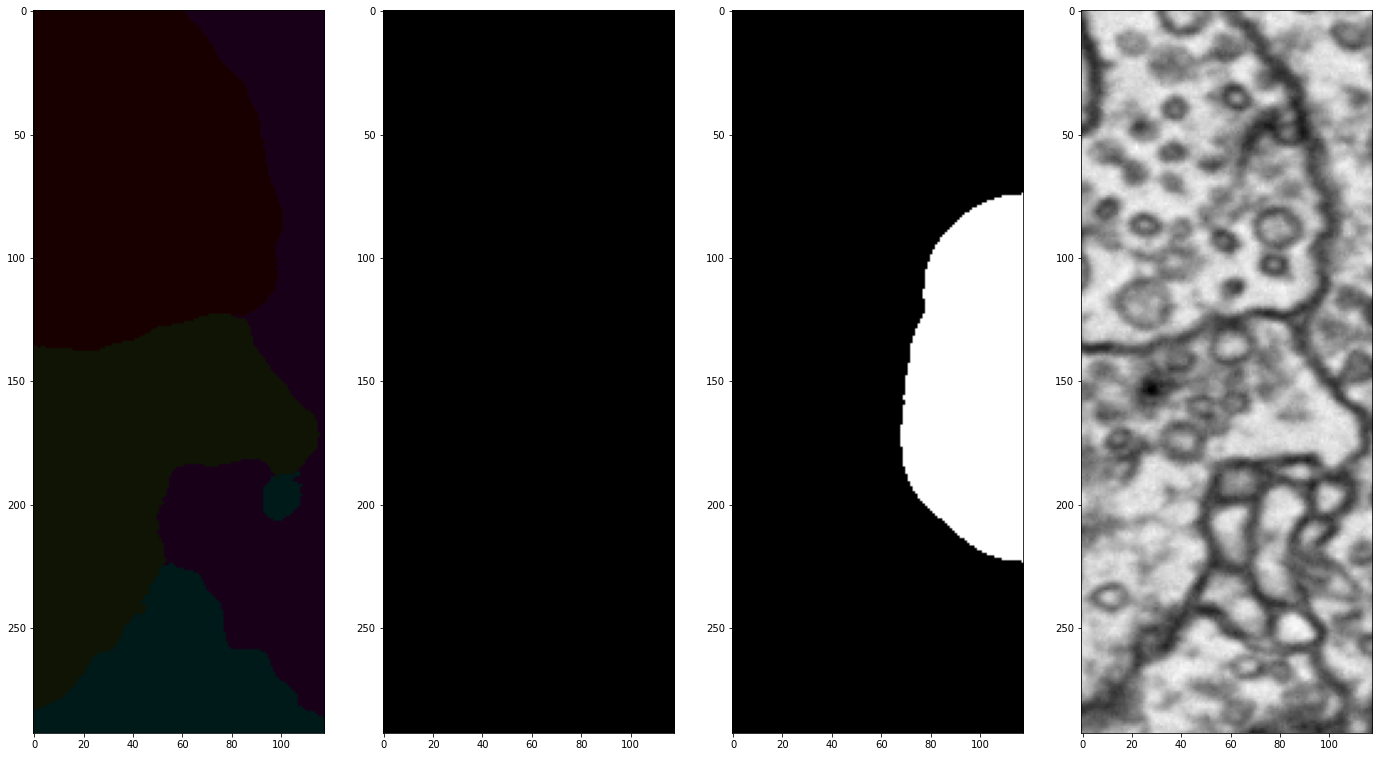

In [70]:
from skimage.segmentation import expand_labels

patch_size = (1,16,16)

c = random.choice(classes)
indices = np.argwhere(label == c)

mins = np.amin(indices,axis=0)
maxs = np.amax(indices,axis=0)
expd_amt = 40 # how much to expand the label for context is x,y

# convert ranges
border = (4, expd_amt, expd_amt)
vol_shape = (125, 1250, 1250)
print(mins, maxs)
for i in range(3):
    mins[i] = max(mins[i] - border[i], 0)
    maxs[i] = min(maxs[i] + border[i], vol_shape[i]-1)
    
# crop
crop_sl = np.s_[mins[0]:maxs[0]+1,mins[1]:maxs[1]+1,mins[2]:maxs[2]+1]
label_sec = label[crop_sl]
image_sec = image[crop_sl]
coord_sec = np.mgrid[crop_sl]

# add channel for coordinates
image_sec = np.expand_dims(image_sec, 0)
image_sec = np.concatenate((image_sec, coord_sec), axis=0)

# zero other classes
label_sec_b = np.zeros_like(label_sec)
label_sec_b[label_sec == c] = c

expanded = np.zeros_like(label_sec)
# expand label in z,y
for i in range(label_sec_b.shape[2]):
    expanded[:,:,i] = expand_labels(label_sec_b[:,:,i], border[0]//2)

# expand label in z,x
for i in range(expanded.shape[1]):
    expanded[:,i,:] = expand_labels(expanded[:,i,:], border[0]//2)

# expand label in x,y
for i in range(expanded.shape[0]):
    expanded[i,:,:] = expand_labels(expanded[i,:,:], border[1]-border[0])
    


# view
fig, axarr = plt.subplots(1,4)
fig.set_size_inches(24, 20)
i = label_sec.shape[0] //2
i = 0
axarr[0].imshow(label_data(image_sec[0], label_sec)[i])
axarr[1].imshow(label_sec_b[i], cmap='gray')
axarr[2].imshow(expanded[i], cmap='gray')
axarr[3].imshow(image_sec[0, i], cmap='gray')



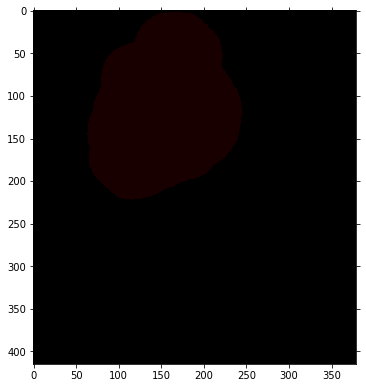

In [136]:
vis_volume(label_data(image_sec[0], expanded))

In [137]:
from einops import rearrange
import math


def patchify(vol, patch_size):
    
    # pad, could do so we pad wth actual data is possible
    vol_shape = vol.shape
    pad_width = []
    for i in range(len(patch_size)):
        left = vol_shape[i] % patch_size[i]
        if left > 0:
            add = patch_size[i] - left
            pad_width.append((math.floor(add/2),math.ceil(add/2)))
        else:
            pad_width.append((0,0))
    padded = np.pad(vol, pad_width)
    vol_shape = padded.shape

    # check
    assert vol_shape[-1] % patch_size[-1] == 0 and vol_shape[-2] % patch_size[-2]== 0 and vol_shape[-3] % patch_size[-3]== 0, 'Image dimensions must be divisible by the patch size.'

    # patch
    pz, py, px = patch_size[-3:]
    arr = rearrange(padded, 'c (z pz) (y py) (x px) -> (z y x) c pz py px', pz=pz, py=py, px=px)
   
    return arr

# drop zero patches
# assumes image_arr and label_arr are in corresponding order
def drop_patches_without_label(image_arr, label_arr, c):
    drop_arr = []
    for i in range(label_arr.shape[0]):
        if c in label_arr[i]:
            drop_arr.append(image_arr[i])
    return np.array(drop_arr)


(78000, 4, 1, 16, 16) (78000, 1, 1, 16, 16)
(17218, 4, 1, 16, 16)


<Figure size 432x288 with 0 Axes>

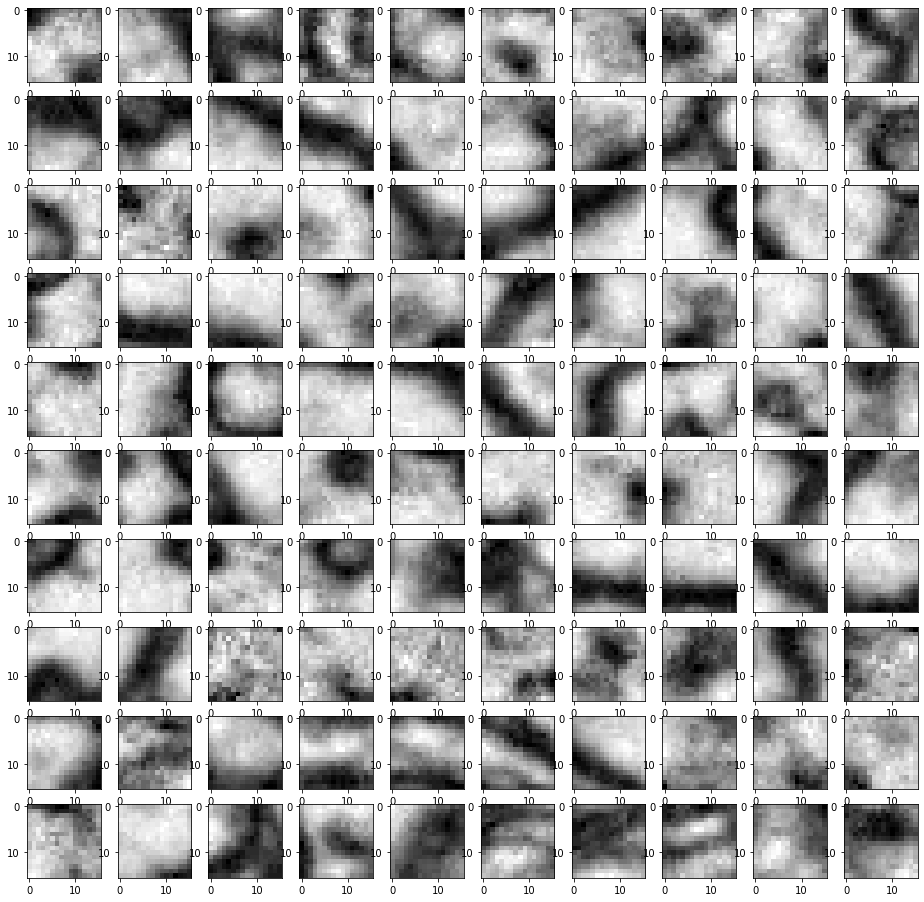

In [138]:
image = image_sec.copy()
label = np.expand_dims(expanded.copy(),0)
combined = np.concatenate((image, label), 0)
combined_arr = patchify(combined, (1, *patch_size))
image_arr = combined_arr[:,:-1,...]
label_arr = combined_arr[:,-1:,...]
print(image_arr.shape, label_arr.shape)
image_arr = drop_patches_without_label(image_arr, label_arr, c)
print(image_arr.shape)
fig = plt.figure()
fig, axarr = plt.subplots(10,10)
fig.set_size_inches(16, 16)
for i in range(0,10):
    for j in range(0,10):
        axarr[i,j].imshow(image_arr[(i*10)+j][0][0], cmap='gray')
plt.show()

In [75]:
recon = np.zeros((125+1,1250+16,1250+16))

for i in range(image_arr.shape[0]):
    patch = image_arr[i]
    val = patch[0]
    sz = val.shape
    coors = patch[1:]
    st = coors[:,0,0,0].astype(int)
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

vis_volume(recon)

NameError: name 'image_arr' is not defined

In [4]:
from neutorch.dataset.utils import from_h5
from neutorch.dataset.proofread import ProofreadDataset

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
true_label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')
pred_label = np.load('../../swin_run/segmentation_700000_sample_A_pad.npy')


If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [57]:
import h5py

with h5py.File('../../swin_run/segmentation_700000_sample_A_pad.h5', 'w') as hf:
    hf.create_dataset("seg",  data=pred_label)

In [59]:
import cc3d

pred_label = cc3d.connected_components(pred_label) 
dataset = ProofreadDataset(image, pred_label, true_label, name=file)


In [62]:
img, lbl = dataset[0]

0


KeyboardInterrupt: 

In [54]:
print(img.shape, lbl.shape)

(166, 4, 1, 16, 16) (166, 1, 1, 16, 16)


In [55]:

recon = np.zeros((125+1,1250+16,1250+16))
recon_label = np.zeros((125+1,1250+16,1250+16, 3))
for j in range(img.shape[0]):
    patch = img[j]
    seg = lbl[j][0]
    val = patch[0]
    sz = val.shape
    coors = patch[1:]
    st = coors[:,0,0,0].astype(int)
    
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

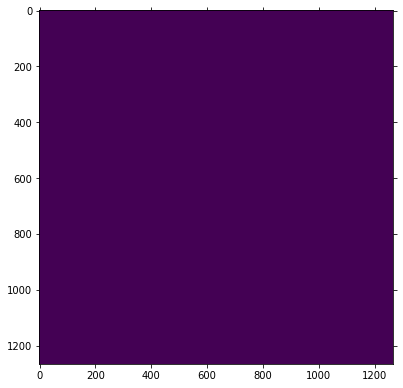

In [56]:
vis_volume(recon)

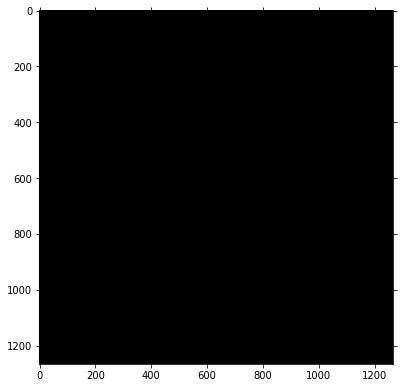

In [72]:
vis_volume(recon_label)